In [1]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict

import json
import copy
#import helper

from PIL import Image

In [2]:
data_dir = 'img'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'


In [3]:
def calculate_accuracy(model):
    #input model, returns none
    #this function prints the accuracy of the model
    model.eval()
    model.to('cuda')
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloaders:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (labels == predicted).sum().item()

    print('Accuracy = ', (100*correct/total))

In [4]:
def load_data(train_dir, valid_dir, test_dir):
    #inputs none and return trainloaders, validloaders, testloaders, image_datasets, dataloaders, and sizes
    train_transforms = transforms.Compose([transforms.Resize((256,256)),
                                           transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    test_transforms = transforms.Compose([transforms.Resize((256,256)),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    # TODO: Load the datasets with ImageFolder
    train_data = datasets.ImageFolder(train_dir, transform = train_transforms)
    valid_data = datasets.ImageFolder(valid_dir, transform = test_transforms)
    test_data = datasets.ImageFolder(test_dir, transform = test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
    trainloaders = torch.utils.data.DataLoader(train_data, batch_size = 1, shuffle = True)
    validloaders = torch.utils.data.DataLoader(valid_data, batch_size = 1)
    testloaders = torch.utils.data.DataLoader(test_data, batch_size = 1)
    image_datasets = {'train': train_data,
                     'valid': valid_data,
                     'test': test_data}
    dataloaders = {'train': trainloaders,
                  'valid': validloaders,
                  'test': testloaders}
    sizes = {'train': len(image_datasets['train']),
            'valid': len(image_datasets['valid'])}
    return trainloaders, validloaders, testloaders, image_datasets, dataloaders, sizes

In [5]:
trainloaders, validloaders, testloaders, image_datasets, dataloaders, sizes = load_data(train_dir, valid_dir, test_dir)

In [7]:
def load_checkpoint(filename):
    #inputs the .pth file and outputs model
    if torch.cuda.is_available():
        checkpoints = torch.load(filename)
    else:
        checkpoints = torch.load(filename, map_location = 'cpu')
    model = models.vgg16(pretrained = True)
    for param in model.parameters():
        param.requires_grad = False

    classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(25088, 4096)),
    ('relu1', nn.ReLU()),
    ('fc4', nn.Linear(4096, 2048)),
    ('relu4', nn.ReLU()),
    ('fc5', nn.Linear(2048, 1024)),
    ('relu5', nn.ReLU()),

    ('fc6', nn.Linear(1024, 57)),
    ('output', nn.LogSoftmax(dim = 1))
    ]))
    model.classifier = classifier
    model.class_to_idx = checkpoints['class_to_idx']
    model.load_state_dict(checkpoints['state_dict'])
    return model


In [8]:
model_new = load_checkpoint('checkpoints.pth')

In [14]:
model_new.state_dict

<bound method Module.state_dict of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
calculate_accuracy(model_new)

Accuracy =  73.66362451108213


In [9]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [10]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    image = Image.open(image_path)
    size = (256,256)
    image = image.resize(size)
    width, height = image.size
    left = (width - 224) / 2
    right = (width + 224) / 2
    top = (height - 224) / 2
    bottom = (height + 224) / 2
    image = image.crop((left, top, right, bottom))
    try:
        np_image = np.array(image) / 255
    
        mean_normal = np.array([0.485, 0.456, 0.406])
        std_normal = np.array([0.229, 0.224, 0.225])
    
        np_image = (np_image - mean_normal) / std_normal
        np_image = np_image.transpose(2, 0, 1)
    except:
        image = image.convert("RGB")
        np_image = np.array(image) / 255
    
        mean_normal = np.array([0.485, 0.456, 0.406])
        std_normal = np.array([0.229, 0.224, 0.225])
    
        np_image = (np_image - mean_normal) / std_normal
        np_image = np_image.transpose(2, 0, 1)
    return np_image
    
    
    # TODO: Process a PIL image for use in a PyTorch model

In [43]:
image_path = './img2/test2.png'
image = process_image(image_path)

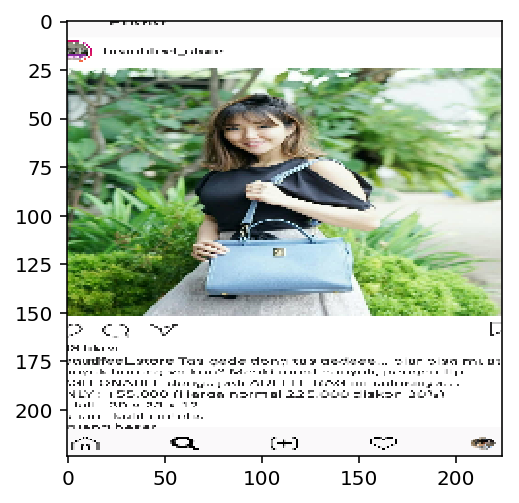

In [38]:
imshow(image)

In [13]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    image = process_image(image_path)
    
    img = torch.from_numpy(image).type(torch.FloatTensor)
    img.unsqueeze_(0)
    model.to('cpu')
    output = model.forward(img)
    probs = torch.exp(output)
    top_5_probs, top_5_labels = probs.topk(5)
    return top_5_probs, top_5_labels
    # TODO: Implement the code to predict the class from an image file

In [14]:
probs, classes = predict(image_path, model_new)

In [25]:
print(probs)
print(classes)

tensor([[9.9999e-01, 3.3728e-06, 1.7014e-06, 1.4685e-06, 6.6837e-07]],
       grad_fn=<TopkBackward>)
tensor([[10, 49, 40, 54,  2]])


In [15]:
def create_label(classes, model):
    #this function convert labels from tensor to list
    #input classes and model
    #returns label in the form of list
    
    #convert tensor to array, and array to list
    labels_list = classes.numpy()
    labels_list = labels_list.tolist()
    labels = []
    for i in labels_list:
        for j in i:
            labels.append(j)
    
    #creating dictionary from class_to_idx
    model_dict = model.class_to_idx
    #switch the keys and values from the dictionary
    model_dict2 = {y:x for x,y in model_dict.items()}
    
    #convert the list element in labels into the values in model dict
    convert_list = []
    for i in labels:
        convert_list.append(model_dict2[i])
    return convert_list

In [16]:
def create_probs(probs):
    #this function convert probs from tensor to list
    
    #converting probs from tensor to ndarray and ndarray to list
    probs_array = probs.detach().numpy()
    probs_list1 = probs_array.tolist()
    probs_list = []
    for i in probs_list1:
        for j in i:
            probs_list.append(j)
    return probs_list

In [17]:
def create_plot(image_path, model):
    #this function input image_path (the jpg file) and model and returns none
    #this function is used to plot the prediction of the image 
    
    #set up the plots
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    
    #process image
    image = process_image(image_path)
    #image_title = cat_to_name[image_path.split('/')[3]]
    
    #show the image
    imshow(image,ax)
    
    #calculate probs and classes
    probs, classes = predict(image_path, model)
    
    #converting probs and classes to list
    labels = create_label(classes, model)
    probs_list = create_probs(probs)
    
    #creating horizontal bar chart
    plt.figure(figsize = (6,10))
    plt.subplot(2,1,2)
    plt.barh(labels, probs_list)

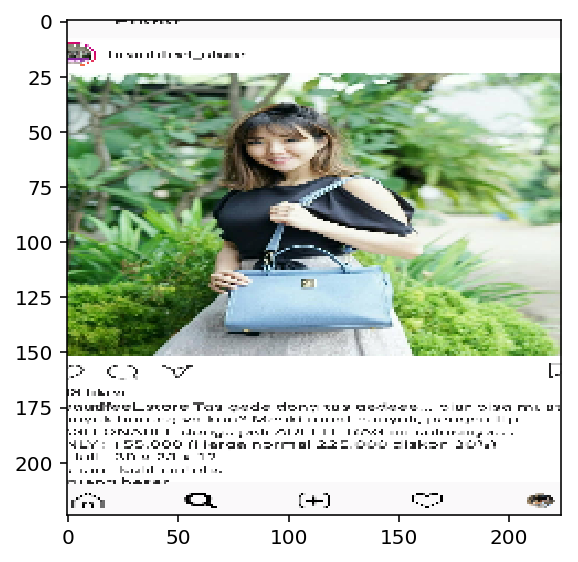

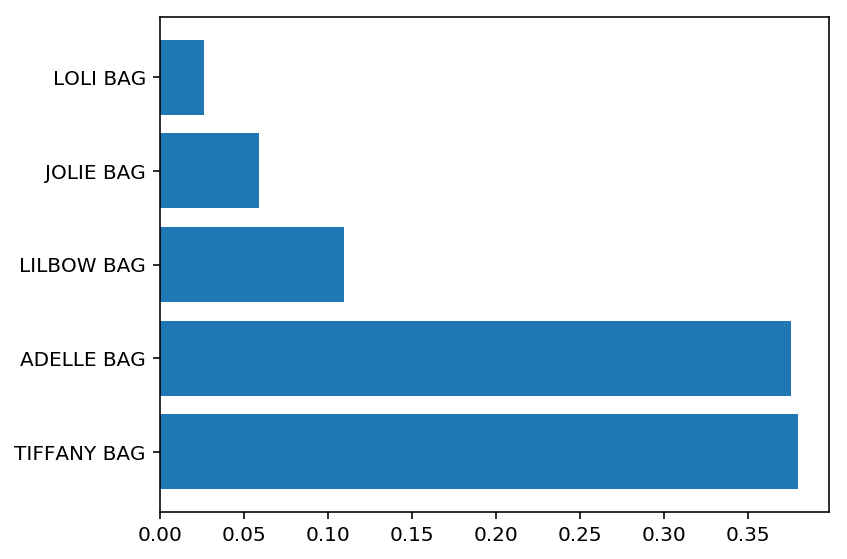

In [44]:
create_plot(image_path, model_new)